In [3]:
#Import bibs
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
#%matplotlib notebook
import itertools
import os
import sys
from IPython.display import display, HTML

In [4]:
#Import funtions
sys.path.insert(0, '../Implementation_Events_Kopie/')
from Event_detection_functions import *
sys.path.insert(0, '../')
from IMPORT_DATAFRAME_JSON_HDF5 import *
from plot_transients_function import *

In [5]:
#Set up the date to plot
day = '07'
month = '08'
year = '2017'
date_HDF5 = year+'-'+month+'-'+day
HDF5_filepath = '../../../HDF5/'+date_HDF5+'/'

In [6]:
#Import transients of the day
transients_path = '../../../transients_new/'+month+'/'
#transients_clean
#transients = import_trasient_from_file(transients_path)
#transients prepared
transients = pd.read_pickle('G:/Dropbox/Dropbox/Uni/Master/Master 6/PUEL/04_Data/Transients_with_charging_plugin_info_05_02_to_23_09/df_transients_charging_plugin_'+month)

In [7]:
transients['begin_timestamp_string'] = transients['begin_timestamp_string'].apply(convert_to_datetime)
transients = transients[transients['begin_timestamp_string'].dt.day == int(day)]
transients['minute_index'] = transients['begin_timestamp_string'].dt.hour*60+transients['begin_timestamp_string'].dt.minute

In [8]:
#transients = transients[transients['plugin_on_this_phase']==True]

In [9]:
#Import corresponding HDF5 files for the date and convert them to minute values
Phase_1,P_Phase_1,no_load_p_1=[],[],[]
Phase_2,P_Phase_2,no_load_p_2=[],[],[]
Phase_3,P_Phase_3,no_load_p_3=[],[],[]
Phase_dictionary = {1:Phase_1, 2:Phase_2,3:Phase_3}
no_load_p_dict = {1:no_load_p_1, 2:no_load_p_2,3:no_load_p_3}
for Phase in [1,2,3]:
    Phase_dictionary[Phase]=pd.read_hdf('../../../HDF5/'+date_HDF5+'/phase_'+str(Phase)+'_' + date_HDF5+'.h5',columns =['P', 'timestamps'])
    Phase_dictionary[Phase]=Phase_dictionary[Phase].groupby(np.arange(len(Phase_dictionary[Phase]))//300).mean()
    Phase_dictionary[Phase]['P_delta']=Phase_dictionary[Phase]['P'].diff()
    no_load_p_dict[Phase]=Phase_dictionary[Phase].iloc[0]['P']

In [10]:
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                       'Ladevorgang', 'Status', 'Ladeleistung',
                                       'minuten_index_Abschaltung','timestamp_abschalt'])

#check if event_df already exists
if (os.path.exists(HDF5_filepath+date_HDF5+'_event_df.pkl') == False):

#Simulate event detection code
    backtrack_timesteps=7
    with progressbar.ProgressBar(max_value=len(Phase_dictionary[1])) as bar:
        for minute_day in range(2,max(len(Phase_dictionary[1]),len(Phase_dictionary[2]),len(Phase_dictionary[3]))):
            bar.update(minute_day)
            # Insert this in the update routine after the power_today_minute.csv export
            # The following variables have to be set to the corresponding dataframe in the environment (export to power_today_minute_x.csv)
            phase_dict = {1:P_Phase_1, 2:P_Phase_2, 3:P_Phase_3}
            for Phase in [1,2,3]:
                phase_dict[Phase]=Phase_dictionary[Phase][max(0,minute_day-backtrack_timesteps):minute_day]
                Event_df = detect_switch_event(phase_dict[Phase], Phase, Event_df, no_load_p_dict[Phase])
    Event_df.to_pickle(HDF5_filepath+date_HDF5+'_event_df.pkl')
else:
    Event_df = pd.read_pickle(HDF5_filepath+date_HDF5+'_event_df.pkl')

<IPython.core.display.Javascript object>


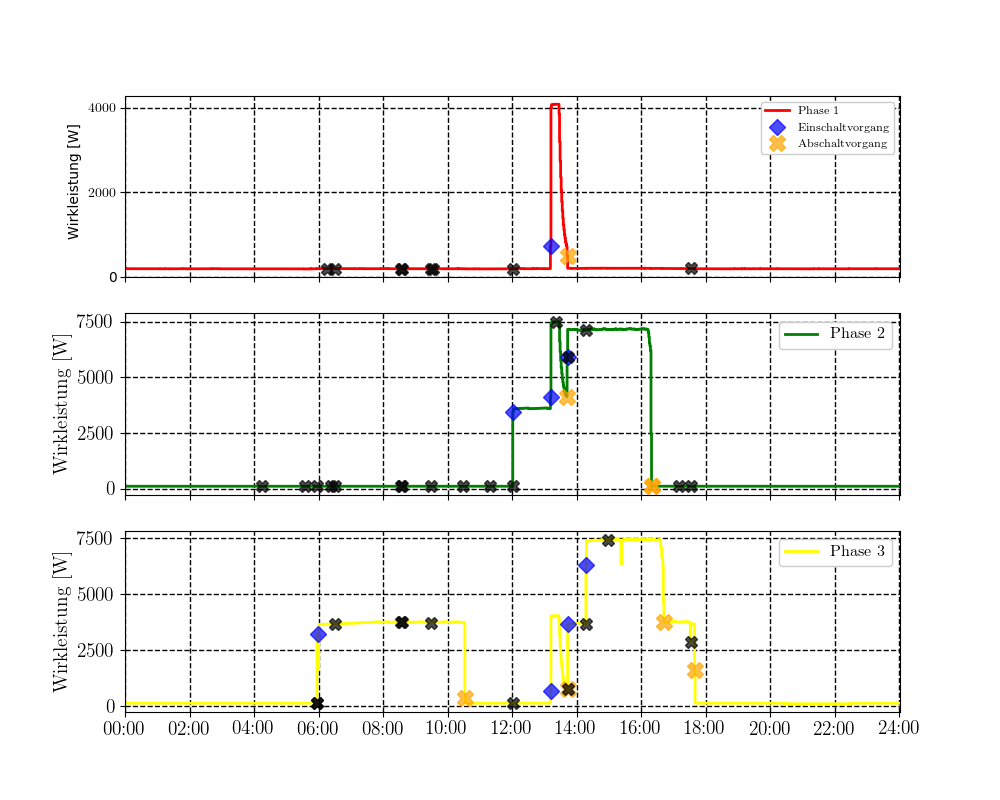

In [11]:
colors_phase = ['red','green','yellow']
plt.figure(figsize=(10,8))
for Phase in [1,2,3]:
    Phase_P = Phase_dictionary[Phase]
    plt.subplot(310+Phase)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    if ((Phase==2) | (Phase==3)):
        plt.legend(loc='upper right', frameon=True, fontsize = 'small',framealpha=1)
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=8,alpha=.7, label='Einschaltvorgang')
    
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']]['P'], "X",color="orange", markersize=11,alpha=.7, label='Abschaltvorgang')
    if Phase==1:
        plt.legend(loc='upper right', frameon=True, fontsize = 'small',framealpha=1)
    plt.plot(transients[transients.phase_num == Phase]['minute_index'],Phase_P.iloc[transients[transients.phase_num==Phase]['minute_index']]['P'],"X", color="black", markersize=8,alpha=.7, label='Transiente')

    plt.rcParams.update({'font.size': 14})
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,len(Phase_P)])
    if ((Phase==1) | (Phase==2)):
        plt.xticks(range(0,len(Phase_P),120),[])
    else:
        plt.xticks(range(0,len(Phase_P),120),('00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00','24:00'))
    plt.ylabel('Wirkleistung [W]')
    plt.savefig('G:/Dropbox/Dropbox/Uni/Master/Master 6/PUEL/06_Ausarbeitung/PUEL_Ausarbeitung/Kapitel3/'+day+'_'+month+'_3_Phasen_P.pdf')
    #plt.savefig("G:\Dropbox\Dropbox\Uni\Master\Master 6\PUEL\06_Ausarbeitung\PUEL_Ausarbeitung\Kapitel3\")+str(day)+str(month)+'.pdf')
#from matplotlib2tikz import save as tikz_save
#tikz_save('test.tex')

<IPython.core.display.Javascript object>


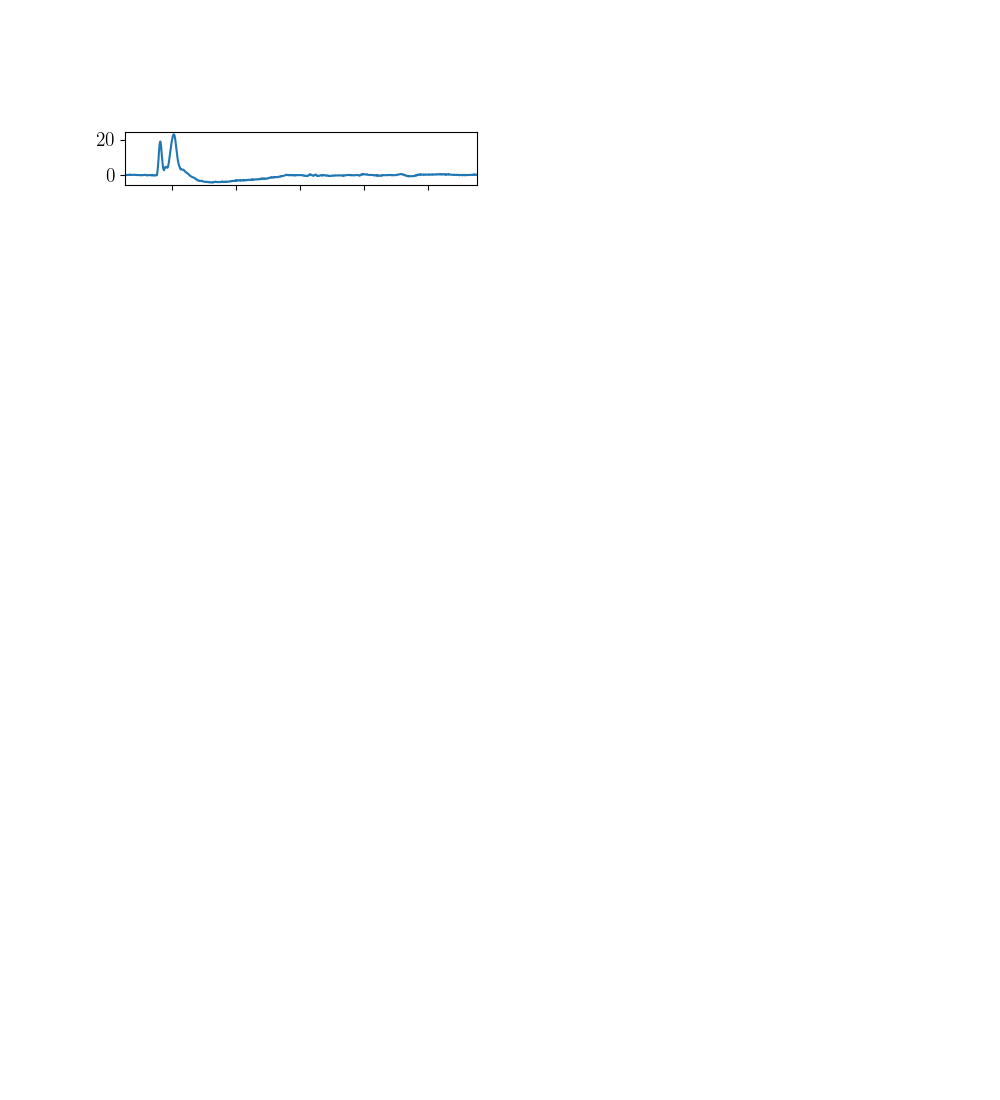

In [12]:
transients_1 = transients[(transients['phase_num']==2) & (transients['plugin']==False)]
plot_transients(transients_1,len(transients_1)-1,'filtered_signal',2)

In [89]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.502078e+09,3,358,aus,checked,3514.76,633,1.50209e+09
1,1.502100e+09,2,722,aus,checked,3478.3,822,1.50211e+09
2,1.502104e+09,1,792,aus,checked,3877.45,823,1.50211e+09
3,1.502104e+09,2,792,aus,checked,3873.89,980,1.50212e+09
4,1.502104e+09,3,792,aus,checked,3905.25,1003,1.50212e+09
5,1.502106e+09,2,823,aus,checked,2906.27,980,1.50212e+09
6,1.502106e+09,3,824,aus,checked,2971.18,823,1.50211e+09
7,1.502108e+09,3,858,aus,checked,3653.93,1060,1.50212e+09


In [42]:
Phase_P['timestamp_real']=Phase_P['timestamp'].apply(convert_to_datetime)

AttributeError: 'float' object has no attribute 'split'

In [59]:
from matplotlib2tikz import save as tikz_save

In [94]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.502078e+09,3,358,aus,checked,3514.76,633,1.50209e+09
1,1.502100e+09,2,722,aus,checked,3478.3,822,1.50211e+09
2,1.502104e+09,1,792,aus,checked,3877.45,823,1.50211e+09
3,1.502104e+09,2,792,aus,checked,3873.89,980,1.50212e+09
4,1.502104e+09,3,792,aus,checked,3905.25,1003,1.50212e+09
5,1.502106e+09,2,823,aus,checked,2906.27,980,1.50212e+09
6,1.502106e+09,3,824,aus,checked,2971.18,823,1.50211e+09
7,1.502108e+09,3,858,aus,checked,3653.93,1060,1.50212e+09
